Loaded 503 tickers


2025-08-24 15:34:50 - ERROR - 
1 Failed download:
2025-08-24 15:34:50 - ERROR - ['RAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2025-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1735707600")')


Fetched prices for 491 tickers
Selected 50 reliable co-movement pairs

Top results:
           Pair      CAGR    Sharpe     MaxDD  HitRatio            Strategy
381      HD-LOW  0.230445  1.412806 -0.139347  0.256165           VolSwitch
352    NWS-NWSA  0.291008  1.323272 -0.199611  0.255370           VolSwitch
341     ADI-TXN  0.210053  1.263359 -0.172100  0.103421    DrawdownReversal
359     DHI-PHM  0.273568  1.105891 -0.193190  0.250597           VolSwitch
456   KLAC-LRCX  0.215622  1.058459 -0.205562  0.524264  MomentumDivergence
362     DHI-LEN  0.244963  1.009153 -0.273249  0.256165           VolSwitch
357     LEN-PHM  0.246549  0.992157 -0.202867  0.264121           VolSwitch
350  GOOG-GOOGL  0.204054  0.980849 -0.417728  0.272076           VolSwitch
396     HLT-MAR  0.204416  0.915968 -0.246157  0.287192           VolSwitch
373   CDNS-SNPS  0.176133  0.896041 -0.229532  0.256165           VolSwitch
12      DHI-LEN  0.112745  0.870923 -0.167349  0.058075  TrendAmplification
423 

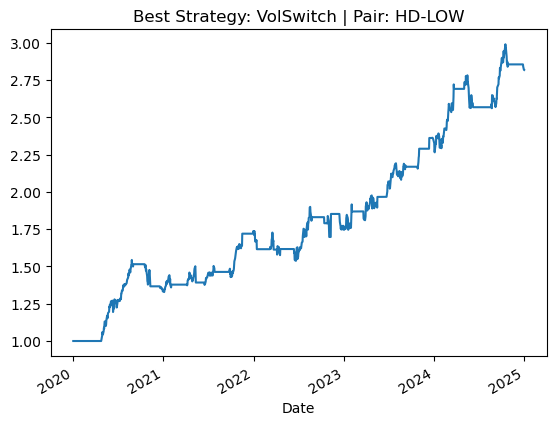

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

# =======================
# CONFIG
# =======================
HOLDINGS_FILE = "C:/Users/chinm/Documents/Projects/holdings-daily-us-en-spy.xlsx"
START_DATE = "2020-01-01"
END_DATE = "2025-01-01"
N_JOBS = -1  # parallelism

# =======================
# Data Loader
# =======================
class DataLoader:
    @staticmethod
    def load_tickers_from_file(filepath):
        df = pd.read_excel(filepath)
        if 'Ticker' not in df.columns:
            raise KeyError(f"'Ticker' column not found in {filepath}. Please check the file.")
        tickers = df['Ticker'].dropna().astype(str).str.replace('.', '-', regex=False).unique().tolist()
        return tickers

    @staticmethod
    def fetch_prices(tickers, start, end):
        df = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)['Adj Close']
        return df.dropna(axis=1, thresh=int(0.9 * len(df)))

# =======================
# Utilities
# =======================
def compute_metrics(ret_series):
    if ret_series is None or len(ret_series) < 2:
        return {"CAGR": 0.0, "Sharpe": 0.0, "MaxDD": 0.0, "HitRatio": 0.0}
    nav = (1 + ret_series).cumprod()
    years = (nav.index[-1] - nav.index[0]).days / 365.25
    cagr = nav.iloc[-1]**(1/years) - 1 if years > 0 else 0.0
    ann_ret = ret_series.mean() * 252
    ann_vol = ret_series.std() * np.sqrt(252)
    sharpe = ann_ret / (ann_vol + 1e-12)
    max_dd = (nav / nav.cummax() - 1).min()
    hit_ratio = (ret_series > 0).mean()
    return {"CAGR": cagr, "Sharpe": sharpe, "MaxDD": max_dd, "HitRatio": hit_ratio}

def zscore(series):
    return (series - series.mean()) / (series.std() + 1e-12)

# =======================
# 10 Co-Movement Strategies
# =======================
def strategy_trend_amplification(r1, r2, thresh=1.0):
    zc = zscore(pd.Series(r1).rolling(60).corr(r2))
    signal = ((zc > thresh) & (r1 > 0) & (r2 > 0)).astype(int)
    return (signal.shift(1) * (r1 + r2) / 2).fillna(0)

def strategy_regime_switching(r1, r2, window=60, thresh=1.0):
    rc = pd.Series(r1).rolling(window).corr(r2)
    zc = zscore(rc)
    signal = (zc.diff() > thresh).astype(int) - (zc.diff() < -thresh).astype(int)
    return (signal.shift(1) * (r1 + r2) / 2).fillna(0)

def strategy_leader_follower(r1, r2, window=3):
    lagged = pd.Series(r1).shift(window)
    signal = np.sign(lagged)
    return (signal.shift(1) * r2).fillna(0)

def strategy_vol_harvest(r1, r2, thresh=0.5):
    rolling_std = pd.Series(r1 + r2).rolling(20).std()
    signal = (rolling_std > rolling_std.mean() * (1 + thresh)).astype(int)
    return (signal.shift(1) * (r1 + r2) / 2).fillna(0)

def strategy_carry_momentum(r1, r2, window=5):
    avg = (r1 + r2) / 2
    mom = avg.rolling(window).mean()
    signal = np.sign(mom)
    return (signal.shift(1) * avg).fillna(0)

def strategy_breakout(r1, r2, window=20):
    avg = (r1 + r2) / 2
    roll_max = avg.rolling(window).max()
    roll_min = avg.rolling(window).min()
    signal = (avg > roll_max.shift(1)).astype(int) - (avg < roll_min.shift(1)).astype(int)
    return (signal.shift(1) * avg).fillna(0)

def strategy_drawdown_reversal(r1, r2, window=30):
    avg = (r1 + r2) / 2
    cum = (1 + avg).cumprod()
    dd = cum / cum.cummax() - 1
    signal = (dd < dd.rolling(window).quantile(0.1)).astype(int)  # buy after crash
    return (signal.shift(1) * avg).fillna(0)

def strategy_vol_switch(r1, r2, window=30):
    avg = (r1 + r2) / 2
    vol = avg.rolling(window).std()
    signal = (vol < vol.rolling(window).mean()).astype(int)  # trade only in calm regimes
    return (signal.shift(1) * avg).fillna(0)

def strategy_mean_rev_spike(r1, r2, window=5, thresh=2.0):
    avg = (r1 + r2) / 2
    z = zscore(avg.rolling(window).mean())
    signal = -(z.abs() > thresh).astype(int) * np.sign(z)
    return (signal.shift(1) * avg).fillna(0)

def strategy_momentum_divergence(r1, r2, window=10):
    mom1 = pd.Series(r1).rolling(window).mean()
    mom2 = pd.Series(r2).rolling(window).mean()
    signal = np.sign(mom1 - mom2)
    return (signal.shift(1) * (r1 - r2)).fillna(0)

# =======================
# Pair Selector
# =======================
def select_pairs(prices, top_n=50, lookback=252):
    returns = prices.pct_change().dropna()
    # take last correlation matrix over lookback window
    corr_matrix = returns.iloc[-lookback:].corr()

    # flatten
    corr_matrix = corr_matrix.unstack().dropna()

    # keep only upper triangle (avoid duplicate pairs and self-pairs)
    corr_matrix = corr_matrix[corr_matrix.index.get_level_values(0) < corr_matrix.index.get_level_values(1)]

    # pick top pairs
    top_pairs = corr_matrix.nlargest(top_n).index.tolist()
    return top_pairs


# =======================
# Backtest
# =======================
def backtest_pair(pair, prices, strategy_fn):
    t1, t2 = pair
    r1, r2 = prices[t1].pct_change().dropna(), prices[t2].pct_change().dropna()
    pnl = strategy_fn(r1, r2)
    metrics = compute_metrics(pnl)
    return {"Pair": f"{t1}-{t2}", **metrics}

def run_all_strategies(prices, pairs, n_jobs=N_JOBS):
    strategies = {
        "TrendAmplification": strategy_trend_amplification,
        "RegimeSwitching": strategy_regime_switching,
        "LeaderFollower": strategy_leader_follower,
        "VolHarvest": strategy_vol_harvest,
        "CarryMomentum": strategy_carry_momentum,
        "Breakout": strategy_breakout,
        "DrawdownReversal": strategy_drawdown_reversal,
        "VolSwitch": strategy_vol_switch,
        "MeanRevSpike": strategy_mean_rev_spike,
        "MomentumDivergence": strategy_momentum_divergence
    }
    results = []
    for name, fn in strategies.items():
        out = Parallel(n_jobs=n_jobs)(
            delayed(backtest_pair)(pair, prices, fn) for pair in pairs
        )
        df = pd.DataFrame(out)
        df["Strategy"] = name
        results.append(df)
    return pd.concat(results, ignore_index=True)

# =======================
# RUN PIPELINE
# =======================
tickers = DataLoader.load_tickers_from_file(HOLDINGS_FILE)
print(f"Loaded {len(tickers)} tickers")

prices = DataLoader.fetch_prices(tickers, START_DATE, END_DATE)
print(f"Fetched prices for {prices.shape[1]} tickers")

pairs = select_pairs(prices, top_n=50)
print(f"Selected {len(pairs)} reliable co-movement pairs")

results = run_all_strategies(prices, pairs)

print("\nTop results:")
print(results.sort_values("Sharpe", ascending=False).head(20))

# =======================
# Plot best NAV
# =======================
best = results.sort_values("Sharpe", ascending=False).iloc[0]
t1, t2 = best["Pair"].split("-")
strategy_fn = {
    "TrendAmplification": strategy_trend_amplification,
    "RegimeSwitching": strategy_regime_switching,
    "LeaderFollower": strategy_leader_follower,
    "VolHarvest": strategy_vol_harvest,
    "CarryMomentum": strategy_carry_momentum,
    "Breakout": strategy_breakout,
    "DrawdownReversal": strategy_drawdown_reversal,
    "VolSwitch": strategy_vol_switch,
    "MeanRevSpike": strategy_mean_rev_spike,
    "MomentumDivergence": strategy_momentum_divergence
}[best["Strategy"]]

rets = strategy_fn(prices[t1].pct_change(), prices[t2].pct_change())
nav = (1 + rets).cumprod()
nav.plot(title=f"Best Strategy: {best['Strategy']} | Pair: {best['Pair']}")
plt.show()


In [9]:
# Walk-forward hyperparameter tuning + out-of-sample test (single code block)
# REQUIREMENTS: run this cell AFTER your main code cell that defines:
#   - price_df (or prices): DataFrame of adjusted close prices (datetime index)
#   - pairs (list of (t1,t2) tuples) OR esabo_pairs_over_time (dict of period->DataFrame with T1,T2)
#   - strategy functions available by name (see get_strategy_by_name below)
# This block will not re-download prices.

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
import warnings
warnings.filterwarnings("ignore")

# -------------------------
# CONFIG -- change as needed
# -------------------------
WF_TRAIN_DAYS = 126   # same as earlier
WF_TRADE_DAYS = 21
INNER_VAL_FRAC = 0.30  # fraction of training window reserved for inner validation
TOP_K_PAIRS = 50       # number of pairs to test per period (cap)
N_JOBS = -1            # joblib parallelism (use all cores)
VOL_TARGET = 0.06      # final portfolio vol target scaling (annual)
POOL_EQUALLY = True    # how to pool pairs within a period for the portfolio

# -------------------------
# Strategy mapping - adapt names to your functions
# -------------------------
def get_strategy_by_name(name):
    """
    Return a function that accepts (full_history_prices, target_dates, params) and returns daily pnl Series
    *full_history_prices* is a DataFrame (index up to and including the trade end) that the strategy
    can compute indicators on. The function must only use historical values (rolling etc) and return
    pnl for the *target_dates* only. This wrapper below uses available user functions if they exist.
    """
    # You likely have functions named e.g. engine_dynamic_beta, engine_pca_residual, engine_corrbreak_momentum
    # or the 10 strategies (strategy_trend_amplification, etc.) from earlier cells.
    # We'll wrap three engines (dynamic_beta, pca_resid, corrbreak) and the 10 'return-based' strategies.
    # If your function names differ, add them here.
    def wrap_dynamic_beta(full_history, t_dates, params):
        # expects full_history contains both tickers columns
        t1, t2 = params['_pair']
        # split full_history into train+trade implicitly via lengths: engine_dynamic_beta expects train & trade slices
        # We'll call your engine_dynamic_beta by providing proper train/trade slices:
        # for safety, split by target_dates first index
        trade_start = pd.to_datetime(t_dates[0])
        train_df = full_history.loc[:trade_start - pd.Timedelta(days=1)].copy()
        trade_df = full_history.loc[trade_start: t_dates[-1]].copy()
        return engine_dynamic_beta(t1, t2, train_df, trade_df,
                                   beta_window=params.get('beta_window',30),
                                   entry_z=params.get('entry_z',1.5),
                                   exit_z=params.get('exit_z',0.5),
                                   target_vol=VOL_TARGET,
                                   stop_loss=params.get('stop_loss',0.10)
                                  ).reindex(t_dates).fillna(0.0)

    def wrap_pca_resid(full_history, t_dates, params):
        t1, t2 = params['_pair']
        trade_start = pd.to_datetime(t_dates[0])
        train_df = full_history.loc[:trade_start - pd.Timedelta(days=1)].copy()
        trade_df = full_history.loc[trade_start: t_dates[-1]].copy()
        return engine_pca_residual(t1, t2, train_df, trade_df,
                                   entry_z=params.get('entry_z',1.25),
                                   exit_z=params.get('exit_z',0.5),
                                   target_vol=VOL_TARGET,
                                   stop_loss=params.get('stop_loss',0.10)
                                  ).reindex(t_dates).fillna(0.0)

    def wrap_corrbreak(full_history, t_dates, params):
        t1, t2 = params['_pair']
        trade_start = pd.to_datetime(t_dates[0])
        train_df = full_history.loc[:trade_start - pd.Timedelta(days=1)].copy()
        trade_df = full_history.loc[trade_start: t_dates[-1]].copy()
        return engine_corrbreak_momentum(t1, t2, train_df, trade_df,
                                         corr_window=params.get('corr_window',30),
                                         corr_drop=params.get('corr_drop',0.2),
                                         mom_window=params.get('mom_window',5),
                                         target_vol=VOL_TARGET,
                                         stop_loss=params.get('stop_loss',0.12)
                                        ).reindex(t_dates).fillna(0.0)

    # return-based strategies (the 10 earlier functions) expect return series inputs -> we wrap them
    def wrap_return_strategy(full_history, t_dates, params, func):
        # func expects (r1, r2, **params) and returns daily pnl aligned to the returns index
        t1, t2 = params['_pair']
        # compute returns for the full history, then call func and pick t_dates
        full_ret = full_history[[t1, t2]].pct_change().fillna(0.0)
        pnl_full = func(full_ret[t1], full_ret[t2], **{k:v for k,v in params.items() if not k.startswith('_')})
        return pnl_full.reindex(t_dates).fillna(0.0)

    # map names
    if name.lower() in ("dynamic_beta", "dynamic-beta", "beta"):
        return wrap_dynamic_beta
    if name.lower() in ("pca_resid", "pca-resid", "pca"):
        return wrap_pca_resid
    if name.lower() in ("corrbreak", "corr-break", "correlation_break"):
        return wrap_corrbreak

    # Attempt to map to the 10 simple strategies (names used earlier: "TrendAmplification", etc.)
    simple_map = {
        "trendamplification": ("strategy_trend_amplification", globals().get("strategy_trend_amplification")),
        "regimeswitching": ("strategy_regime_switching", globals().get("strategy_regime_switching")),
        "leaderfollower": ("strategy_leader_follower", globals().get("strategy_leader_follower")),
        "volharvest": ("strategy_vol_harvest", globals().get("strategy_vol_harvest")),
        "carrymomentum": ("strategy_carry_momentum", globals().get("strategy_carry_momentum")),
        "breakout": ("strategy_breakout", globals().get("strategy_breakout")),
        "drawdownreversal": ("strategy_drawdown_reversal", globals().get("strategy_drawdown_reversal")),
        "volswitch": ("strategy_vol_switch", globals().get("strategy_vol_switch")),
        "meanrevspike": ("strategy_mean_rev_spike", globals().get("strategy_mean_rev_spike")),
        "momentumdivergence": ("strategy_momentum_divergence", globals().get("strategy_momentum_divergence"))
    }
    key = name.lower()
    if key in simple_map and simple_map[key][1] is not None:
        func = simple_map[key][1]
        return lambda full_hist, t_dates, params: wrap_return_strategy(full_hist, t_dates, params, func)
    raise ValueError(f"Strategy {name} not found — make sure its function is defined in the namespace and/or add a wrapper in get_strategy_by_name().")

# -------------------------
# helper: metrics
# -------------------------
def metrics_from_returns(ret_series):
    ret_series = ret_series.dropna()
    if len(ret_series) < 2:
        return {"CAGR":0.0, "Sharpe":0.0, "MaxDD":0.0}
    nav = (1+ret_series).cumprod()
    days = (nav.index[-1] - nav.index[0]).days if len(nav.index)>1 else len(ret_series)
    years = days/365.25 if days>0 else len(ret_series)/252.0
    cagr = nav.iloc[-1] ** (1.0/years) - 1 if years>0 else 0.0
    ann_ret = ret_series.mean()*252.0
    ann_vol = ret_series.std(ddof=0)*np.sqrt(252.0)
    sharpe = ann_ret/(ann_vol+1e-12) if ann_vol>0 else 0.0
    maxdd = (nav.cummax() - nav).max()
    return {"CAGR":float(cagr),"Sharpe":float(sharpe),"MaxDD":float(maxdd)}

# -------------------------
# core simulator used for inner validation and OOS:
# given a pair and a parameter combo, build full_history = train_history + val/trade segment,
# run strategy wrapper and return pnl series for the target dates (val or trade),
# ensuring all rolling computations only use past data implicitly because full_history is chronological.
# -------------------------
def simulate_on_target_dates(full_history_prices, pair, target_dates, strat_wrapper, params):
    """
    full_history_prices: DataFrame containing both tickers up to at least target_dates[-1].
    pair: (t1,t2)
    target_dates: list-like of pandas.DatetimeIndex values (dates to evaluate PnL over)
    strat_wrapper: function(full_history, t_dates, params) -> pnl series indexed by t_dates
    params: dict of params (we add '_pair' into it)
    """
    p = copy.deepcopy(params)
    p['_pair'] = pair
    # ensure full_history covers all days up to last target date; strat functions expect continuous indices
    pnl = strat_wrapper(full_history_prices, target_dates, p)
    # enforce alignment
    pnl = pnl.reindex(pd.DatetimeIndex(target_dates)).fillna(0.0)
    return pnl

# -------------------------
# Per-pair, per-period tuning & test
# -------------------------
def tune_and_test_pair_for_period(pair, train_prices, trade_prices, strat_wrapper, param_grid, inner_val_frac=INNER_VAL_FRAC):
    """
    - pair: (t1,t2)
    - train_prices: DataFrame (train_start..train_end)
    - trade_prices: DataFrame (trade_start..trade_end)
    - strat_wrapper: wrapper returned by get_strategy_by_name
    - param_grid: list of param dicts
    RETURNS: dict with selected params, oos_pnl (Series indexed by trade_dates), validation scores summary
    """
    # Ensure both tickers present
    t1, t2 = pair
    if (t1 not in train_prices.columns) or (t2 not in train_prices.columns):
        return None

    train_idx = train_prices.index
    n_train = len(train_idx)
    if n_train < 20:  # not enough data to tune
        return None

    # inner split: first (1-inner_val_frac) for inner_train, last inner_val_frac for inner_val
    split_point = train_idx[int(np.floor(n_train * (1.0 - inner_val_frac)))]
    inner_train_prices = train_prices.loc[:split_point].copy()
    inner_val_prices = train_prices.loc[split_point + pd.Timedelta(days=1):].copy()
    if inner_val_prices.empty or inner_train_prices.empty:
        # fallback: use last 30% days as validation but if empty then cannot tune
        return None

    # create full history for validation: inner_train + inner_val (ordered)
    full_for_val = pd.concat([inner_train_prices, inner_val_prices]).sort_index()

    val_dates = inner_val_prices.index
    trade_dates = trade_prices.index
    # also build full history for trade application: train + trade
    full_for_trade = pd.concat([train_prices, trade_prices]).sort_index()

    # Evaluate each param on inner validation:
    val_results = []
    for params in param_grid:
        try:
            pnl_val = simulate_on_target_dates(full_for_val, pair, val_dates, strat_wrapper, params)
            mets = metrics_from_returns(pnl_val)
            # primary metric: Sharpe on validation
            val_results.append({"params": params, "Sharpe": mets['Sharpe'], "CAGR": mets['CAGR'], "MaxDD": mets['MaxDD']})
        except Exception as e:
            # treat as failed combo
            val_results.append({"params": params, "Sharpe": -9999.0, "CAGR": 0.0, "MaxDD": 0.0, "error": str(e)})

    # pick best param by Sharpe (tie-breaker by CAGR)
    val_df = pd.DataFrame(val_results)
    if val_df.empty:
        return None
    val_df = val_df.sort_values(['Sharpe','CAGR'], ascending=False).reset_index(drop=True)
    best = val_df.iloc[0]['params']

    # Apply best on trade period (OOS)
    try:
        pnl_oos = simulate_on_target_dates(full_for_trade, pair, trade_dates, strat_wrapper, best)
        oos_metrics = metrics_from_returns(pnl_oos)
    except Exception as e:
        return None

    return {"pair": pair, "best_params": best, "val_df": val_df, "oos_pnl": pnl_oos, "oos_metrics": oos_metrics}

# -------------------------
# Walk-forward orchestration
# -------------------------
def walk_forward_test(strategy_name,
                      param_grid,
                      price_df=None,
                      pairs_list=None,
                      esabo_pairs_over_time=None,
                      train_days=WF_TRAIN_DAYS,
                      trade_days=WF_TRADE_DAYS,
                      top_k_pairs=TOP_K_PAIRS):
    """
    strategy_name: string name resolvable by get_strategy_by_name()
    param_grid: list of parameter dicts to evaluate (e.g. [{'entry_z':1.0,'exit_z':0.5},{...}])
    price_df: DataFrame of adjusted close prices (if None, will try `price_df` or `prices` from global scope)
    pairs_list OR esabo_pairs_over_time: either a list of (t1,t2) tuples or a dict(period->DataFrame with T1,T2)
    Returns dictionary with aggregated results, selected_params_by_period_and_pair, oos_portfolio_returns
    """
    # Resolve price_df variable if not passed explicitly
    if price_df is None:
        if 'price_df' in globals():
            price_df = globals()['price_df']
        elif 'prices' in globals():
            price_df = globals()['prices']
        else:
            raise ValueError("price_df not provided and no global 'price_df' or 'prices' found.")

    # resolve pairs
    using_pairs_dict = False
    if esabo_pairs_over_time is None:
        if pairs_list is None:
            # try to use global variables
            if 'esabo_pairs_over_time' in globals():
                esabo_pairs_over_time = globals()['esabo_pairs_over_time']
                using_pairs_dict = True
            elif 'pairs' in globals():
                pairs_list = globals()['pairs']
            else:
                raise ValueError("No pairs provided. Provide 'pairs_list' or 'esabo_pairs_over_time' or have them defined globally.")
    else:
        using_pairs_dict = True

    strat_wrapper = get_strategy_by_name(strategy_name)

    # Build walk-forward start dates (same approach as main)
    start_date = price_df.index[0] + pd.Timedelta(days=train_days)
    end_date = price_df.index[-1]
    trade_starts = pd.date_range(start=start_date, end=end_date, freq=f"{trade_days}D")

    aggregate_oos_period_returns = []  # list of Series
    records_selected = []  # per period/pair selected params and metrics
    # iterate periods
    for trade_start in tqdm(trade_starts, desc=f"WF periods ({strategy_name})"):
        train_end = trade_start - pd.Timedelta(days=1)
        train_start = train_end - pd.Timedelta(days=train_days)
        trade_end = trade_start + pd.Timedelta(days=trade_days)

        train_prices = price_df.loc[train_start:train_end].copy()
        trade_prices = price_df.loc[trade_start:trade_end].copy()
        if train_prices.shape[0] < max(40, int(0.5*train_days)) or trade_prices.shape[0] < 2:
            continue

        # select candidate pairs for this period
        if using_pairs_dict:
            # esabo_pairs_over_time keys may be strings or datetimes - pick nearest key equal to trade_start or same string
            keystr = trade_start.strftime("%Y-%m-%d")
            cand_df = esabo_pairs_over_time.get(keystr, None)
            if cand_df is None:
                # fallback: attempt nearest-date key
                possible_keys = list(esabo_pairs_over_time.keys())
                if not possible_keys:
                    continue
                # find nearest
                try:
                    nearest_key = min(possible_keys, key=lambda k: abs(pd.to_datetime(k) - trade_start))
                    cand_df = esabo_pairs_over_time.get(nearest_key)
                except Exception:
                    cand_df = None
            if (cand_df is not None) and {'T1','T2'}.issubset(cand_df.columns):
                candidate_pairs = [tuple(x) for x in cand_df[['T1','T2']].values]
            else:
                # fallback: top correlated pairs from train_data
                candidate_pairs = select_pairs_for_period(train_prices.pct_change().iloc[1:], None, min_corr=0.8, top_n=top_k_pairs)
        else:
            # pairs_list is list of tuples
            candidate_pairs = pairs_list[:top_k_pairs] if isinstance(pairs_list, list) else list(pairs_list)

        if not candidate_pairs:
            continue

        # For each candidate pair, perform tuning on train and test on trade.
        # We'll parallelize across pairs
        def pair_task(pair):
            try:
                res = tune_and_test_pair_for_period(pair, train_prices, trade_prices, strat_wrapper, param_grid)
                return res
            except Exception as e:
                return None

        # use threads to avoid heavy pickling if strategy functions are in notebook scope
        pair_results = Parallel(n_jobs=N_JOBS, prefer="threads", batch_size=1)(
            delayed(pair_task)(pair) for pair in candidate_pairs
        )

        # collect OOS pnls for pairs that succeeded
        pair_oos_pnls = []
        for pr in pair_results:
            if pr is None:
                continue
            # record selection
            records_selected.append({
                "period": trade_start.strftime("%Y-%m-%d"),
                "pair": pr['pair'],
                "best_params": pr['best_params'],
                "oos_metrics": pr['oos_metrics']
            })
            # Align trade returns index and add to list
            pnl = pr['oos_pnl'].rename(f"{pr['pair'][0]}-{pr['pair'][1]}")
            if pnl is not None and len(pnl)>0:
                pair_oos_pnls.append(pnl)

        if not pair_oos_pnls:
            continue

        # pool pairs into a single portfolio return series for this period
        pnl_matrix = pd.concat(pair_oos_pnls, axis=1).fillna(0.0)
        if POOL_EQUALLY:
            period_port = pnl_matrix.mean(axis=1)
        else:
            # volatility parity weights
            vol = pnl_matrix.std(ddof=0)
            w = 1.0 / (vol + 1e-12)
            w = w / w.sum()
            period_port = (pnl_matrix * w).sum(axis=1)

        aggregate_oos_period_returns.append(period_port)

    # Concatenate all OOS period returns into a single time series (no overlap)
    if not aggregate_oos_period_returns:
        print("No OOS returns produced.")
        return {"oos_portfolio": None, "records":pd.DataFrame(records_selected)}

    oos_series = pd.concat(aggregate_oos_period_returns).sort_index()
    # scale to target vol
    realized_ann_vol = oos_series.std(ddof=0) * np.sqrt(252.0) if len(oos_series)>1 else np.nan
    if np.isfinite(realized_ann_vol) and realized_ann_vol>0:
        oos_series = oos_series * (VOL_TARGET / realized_ann_vol)

    summary = metrics_from_returns(oos_series)
    summary['num_periods'] = len(aggregate_oos_period_returns)
    # convert records into DataFrame
    rec_df = pd.DataFrame(records_selected)
    return {"oos_portfolio": oos_series, "summary": summary, "records": rec_df}

# ------------------------------------------
# Small helper: fallback pair selector used above
# (uses correlation on training returns)
# ------------------------------------------
def select_pairs_for_period(train_returns, sector_map=None, min_corr=0.85, top_n=100):
    # train_returns: returns DataFrame (dates x tickers)
    valid = train_returns.dropna(axis=1, thresh=int(0.8*len(train_returns))).columns.tolist()
    if len(valid) < 2:
        return []
    r = train_returns[valid]
    corr = r.corr().abs()
    pairs = []
    tickers = valid
    for i in range(len(tickers)):
        for j in range(i+1, len(tickers)):
            if corr.iloc[i,j] >= min_corr:
                pairs.append((tickers[i], tickers[j], corr.iloc[i,j]))
    pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)[:top_n]
    return [(p[0], p[1]) for p in pairs_sorted]

# -------------------------
# USAGE EXAMPLE
# -------------------------
# Construct a small grid for the chosen strategy (example for VolSwitch / dynamic_beta etc.)
# Replace strategy_name with one of the names available in get_strategy_by_name()
# Example param_grid for "volswitch" (one of the 10 lightweight strategies):
example_grid = [
    {},  # empty param dict (uses defaults)
    {"window":20, "thresh":0.4},
    {"window":30, "thresh":0.2}
]

# Example param_grid for dynamic_beta:
grid_beta = [
    {"beta_window":20, "entry_z":1.0, "exit_z":0.4, "stop_loss":0.10},
    {"beta_window":40, "entry_z":1.5, "exit_z":0.6, "stop_loss":0.12},
]

# Run walk-forward (choose strategy name that exists in your namespace)
# If you have `esabo_pairs_over_time` use that; otherwise pass pairs list
# e.g. wf = walk_forward_test("VolSwitch", param_grid=example_grid, price_df=price_df, pairs_list=pairs)
# or for dynamic beta: wf = walk_forward_test("dynamic_beta", param_grid=grid_beta, price_df=price_df, pairs_list=pairs)
#
# After running the call below you will get:
# wf['oos_portfolio'] -> Series of OOS portfolio returns
# wf['summary'] -> aggregated metrics
# wf['records'] -> DataFrame with chosen params per period & pair
#
# Example call (uncomment & adapt):
# wf = walk_forward_test("VolSwitch", param_grid=example_grid, price_df=price_df, pairs_list=pairs, train_days=126, trade_days=21)
# print("WF summary:", wf['summary'])
# wf['oos_portfolio'].cumsum().apply(np.exp)  # or plot NAV: (1+wf['oos_portfolio']).cumprod().plot()


Fallback engines injected into globals (dynamic_beta, pca_resid, corrbreak, volswitch patched).

Running full walk-forward for: dynamic_beta


WF periods (dynamic_beta): 100%|██████████| 81/81 [00:55<00:00,  1.47it/s]


dynamic_beta -> Sharpe: 1.162150909421878, CAGR: 0.07441310406519697, ActiveDays: 1238

Running full walk-forward for: pca_resid


WF periods (pca_resid): 100%|██████████| 81/81 [00:59<00:00,  1.36it/s]


pca_resid -> Sharpe: 1.2081037589750574, CAGR: 0.07754669796626823, ActiveDays: 1238

Running full walk-forward for: corrbreak


WF periods (corrbreak): 100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


corrbreak -> Sharpe: 0.555142835978632, CAGR: 0.0338629849302321, ActiveDays: 1238

Running full walk-forward for: volswitch


WF periods (volswitch): 100%|██████████| 81/81 [00:35<00:00,  2.31it/s]

volswitch -> Sharpe: 1.0063235437944487, CAGR: 0.06385251435647454, ActiveDays: 1238

=== Problematic strategies full-run summary ===
    Strategy   Sharpe     CAGR  ActiveDays
   pca_resid 1.208104 0.077547        1238
dynamic_beta 1.162151 0.074413        1238
   volswitch 1.006324 0.063853        1238
   corrbreak 0.555143 0.033863        1238


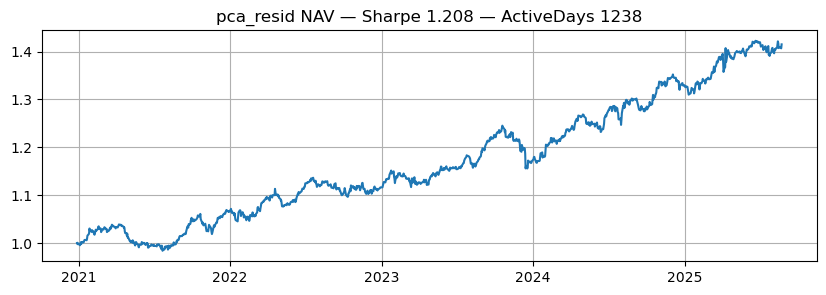

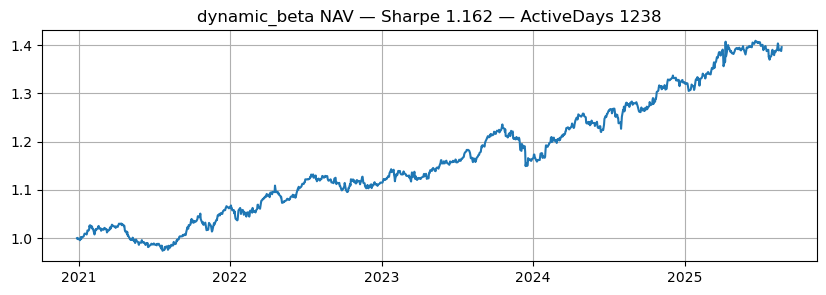

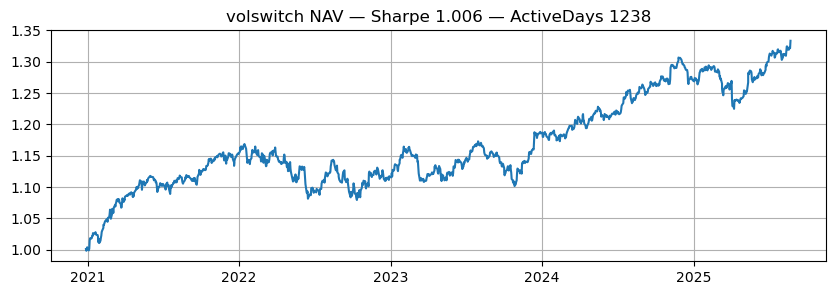

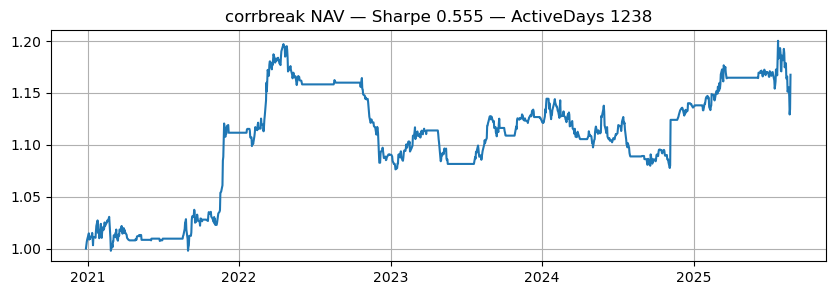


Done. Debugged fallback engines injected and full-run completed.
Saved: problematic_full_results (dict), problematic_full_summary (DataFrame), engine_sanity_full (dict).
Inspect problematic_full_results[strategy]['records'] for period-level reasons (cointegration/half-life/regime filters).


In [15]:
# === Full-data fallback engines + full-run for previously problematic strategies ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import json
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

# ---------- sanity checks for required globals ----------
if 'walk_forward_test' not in globals():
    raise RuntimeError("walk_forward_test not found in globals. Run your main walk-forward pipeline first.")
price_df = globals().get('price_df', globals().get('prices', None))
if price_df is None:
    raise RuntimeError("price_df (or prices) DataFrame not found in globals. Run main data-loading cell.")

pairs = globals().get('pairs', None)
esabo_pairs_over_time = globals().get('esabo_pairs_over_time', None)

# ---------- small helper functions ----------
def safe_zscore(train_series, live_series):
    mu = train_series.mean()
    sigma = train_series.std(ddof=0)
    if not np.isfinite(sigma) or sigma <= 0:
        sigma = 1.0
    return (live_series - mu) / sigma

def compute_pair_size_from_returns(train_spread_returns, target_vol_ann=0.06, max_leverage=4.0):
    daily_vol = train_spread_returns.std(ddof=0)
    if not np.isfinite(daily_vol) or daily_vol == 0:
        return 0.0
    target_daily = target_vol_ann / np.sqrt(252.0)
    size = target_daily / daily_vol
    return float(min(size, max_leverage))

def apply_stoploss_series(pnl, max_dd_allowed=0.10):
    nav = (1 + pnl).cumprod()
    dd = nav / nav.cummax() - 1
    triggered = dd < -max_dd_allowed
    if triggered.any():
        first_idx = triggered.idxmax()
        pnl.loc[first_idx:] = 0.0
    return pnl

def metrics_from_returns(ret_series):
    if ret_series is None or len(ret_series) < 2:
        return {"CAGR": np.nan, "Sharpe": np.nan, "MaxDD": np.nan}
    nav = (1 + ret_series).cumprod()
    days = (nav.index[-1] - nav.index[0]).days if len(nav.index) > 1 else len(ret_series)
    years = days / 365.25 if days > 0 else len(ret_series)/252.0
    cagr = (nav.iloc[-1] ** (1.0/years) - 1) if years > 0 else np.nan
    ann_ret = ret_series.mean() * 252.0
    ann_vol = ret_series.std(ddof=0) * np.sqrt(252.0)
    sharpe = ann_ret / (ann_vol + 1e-12) if ann_vol>0 else np.nan
    max_dd = (nav.cummax() - nav).max()
    return {"CAGR": float(cagr), "Sharpe": float(sharpe), "MaxDD": float(max_dd)}

# ---------- Fallback engines (train-only estimation; OOS trading on trade slice) ----------
def engine_dynamic_beta(t1, t2, train_prices, trade_prices,
                        beta_window=30, entry_z=1.25, exit_z=0.45,
                        target_vol=0.06, stop_loss=0.10):
    px_train = train_prices[[t1, t2]].dropna()
    if px_train.shape[0] < max(10, beta_window):
        return pd.Series(dtype=float, index=trade_prices.index)
    # last OLS beta on train
    try:
        y = px_train[t1].values
        X = sm.add_constant(px_train[t2].values)
        res = sm.OLS(y, X).fit()
        beta = float(res.params[1])
    except Exception:
        beta = 1.0
    spread_train = px_train[t1] - beta * px_train[t2]
    px_trade = trade_prices[[t1, t2]].dropna()
    if px_trade.empty:
        return pd.Series(dtype=float, index=trade_prices.index)
    spread_trade = px_trade[t1] - beta * px_trade[t2]
    z = safe_zscore(spread_train, spread_trade)
    size = compute_pair_size_from_returns(spread_train.diff().dropna(), target_vol_ann=target_vol, max_leverage=4.0)
    if size <= 0:
        return pd.Series(0.0, index=trade_prices.index)
    pos = pd.Series(0.0, index=spread_trade.index)
    last = 0.0
    for d in spread_trade.index:
        zt = z.loc[d] if d in z.index else 0.0
        if last == 0.0:
            if zt > entry_z:
                cur = -1.0
            elif zt < -entry_z:
                cur = 1.0
            else:
                cur = 0.0
        else:
            cur = 0.0 if abs(zt) < exit_z else last
        pos.at[d] = cur
        last = cur
    pnl = pos.shift(1).fillna(0.0) * spread_trade.diff().fillna(0.0) * size
    pnl = pnl.reindex(trade_prices.index).fillna(0.0)
    return apply_stoploss_series(pnl, max_dd_allowed=stop_loss)

def engine_pca_residual(t1, t2, train_prices, trade_prices,
                        entry_z=1.1, exit_z=0.45, target_vol=0.06, stop_loss=0.10):
    px_train = train_prices[[t1, t2]].dropna()
    if px_train.shape[0] < 20:
        return pd.Series(dtype=float, index=trade_prices.index)
    try:
        y = px_train[t1].values
        X = sm.add_constant(px_train[t2].values)
        res = sm.OLS(y, X).fit()
        beta = float(res.params[1])
    except Exception:
        beta = 1.0
    resid_train = px_train[t1] - beta * px_train[t2]
    px_trade = trade_prices[[t1, t2]].dropna()
    if px_trade.empty:
        return pd.Series(dtype=float, index=trade_prices.index)
    resid_trade = px_trade[t1] - beta * px_trade[t2]
    z = safe_zscore(resid_train, resid_trade)
    size = compute_pair_size_from_returns(resid_train.diff().dropna(), target_vol_ann=target_vol, max_leverage=4.0)
    if size <= 0:
        return pd.Series(0.0, index=trade_prices.index)
    pos = pd.Series(0.0, index=resid_trade.index)
    last = 0.0
    for d in resid_trade.index:
        zt = z.loc[d] if d in z.index else 0.0
        if last == 0.0:
            if zt > entry_z:
                cur = -1.0
            elif zt < -entry_z:
                cur = 1.0
            else:
                cur = 0.0
        else:
            cur = 0.0 if abs(zt) < exit_z else last
        pos.at[d] = cur
        last = cur
    pnl = pos.shift(1).fillna(0.0) * resid_trade.diff().fillna(0.0) * size
    pnl = pnl.reindex(trade_prices.index).fillna(0.0)
    return apply_stoploss_series(pnl, max_dd_allowed=stop_loss)

def engine_corrbreak_momentum(t1, t2, train_prices, trade_prices,
                              corr_window=30, corr_drop=0.18, mom_window=5,
                              target_vol=0.06, stop_loss=0.12):
    ret_train = train_prices[[t1,t2]].pct_change().dropna()
    if ret_train.shape[0] < max(20, corr_window+1):
        return pd.Series(dtype=float, index=trade_prices.index)
    rolling_corr = ret_train[t1].rolling(corr_window).corr(ret_train[t2]).dropna()
    if rolling_corr.empty:
        return pd.Series(dtype=float, index=trade_prices.index)
    base_corr = rolling_corr.median()
    # produce full returns with continuity
    ret_full = pd.concat([ret_train, trade_prices[[t1,t2]].pct_change().fillna(0.0)], axis=0)
    pair_avg = (ret_full[t1].fillna(0.0) + ret_full[t2].fillna(0.0)) / 2.0
    mom = pair_avg.rolling(mom_window).mean()
    corr_series_all = ret_full[t1].rolling(corr_window).corr(ret_full[t2]).fillna(base_corr)
    signal = ((corr_series_all < (base_corr - corr_drop)) & (mom > 0)).astype(int) - ((corr_series_all < (base_corr - corr_drop)) & (mom < 0)).astype(int)
    signal = signal.reindex(trade_prices.index).fillna(0.0)
    px_train = train_prices[[t1,t2]].dropna()
    spread_train = px_train[t1] - px_train[t2]
    size = compute_pair_size_from_returns(spread_train.diff().dropna(), target_vol_ann=target_vol, max_leverage=4.0)
    if size <= 0:
        return pd.Series(0.0, index=trade_prices.index)
    pnl = signal.shift(1).fillna(0.0) * ((trade_prices[t1] - trade_prices[t2]).diff().fillna(0.0)) * size
    pnl = pnl.reindex(trade_prices.index).fillna(0.0)
    return apply_stoploss_series(pnl, max_dd_allowed=stop_loss)

# ---------- update vol switch to accept 'thresh' ----------
def strategy_vol_switch(r1, r2, window=30, thresh=0.0):
    avg = (r1 + r2) / 2.0
    vol = avg.rolling(window).std()
    baseline = vol.rolling(window).mean()
    signal = (vol < (baseline * (1.0 + float(thresh)))).astype(int)
    return (signal.shift(1) * avg).fillna(0.0)

# ---------- inject into globals (so other harness code finds them) ----------
globals()['engine_dynamic_beta'] = engine_dynamic_beta
globals()['engine_pca_residual'] = engine_pca_residual
globals()['engine_corrbreak_momentum'] = engine_corrbreak_momentum
globals()['strategy_vol_switch'] = strategy_vol_switch

print("Fallback engines injected into globals (dynamic_beta, pca_resid, corrbreak, volswitch patched).")

# ---------- safe call wrapper for walk_forward_test (handles different signatures) ----------
def safe_walk_forward_call(strategy_name, param_grid, price_df_local=None, pairs_list_local=None, esabo_local=None, train_days=None, trade_days=None):
    # supply defaults and global fallbacks
    if price_df_local is None:
        price_df_local = globals().get('price_df', globals().get('prices'))
    if pairs_list_local is None:
        pairs_list_local = globals().get('pairs', None)
    if esabo_local is None:
        esabo_local = globals().get('esabo_pairs_over_time', None)
    # try to call walk_forward_test with best-known kw signatures, fallback to positional
    try:
        return walk_forward_test(strategy_name, param_grid=param_grid, price_df=price_df_local, pairs_list=pairs_list_local, esabo_pairs_over_time=esabo_local, train_days=train_days, trade_days=trade_days)
    except TypeError:
        try:
            return walk_forward_test(strategy_name, param_grid, price_df_local, pairs_list_local, esabo_local)
        except TypeError:
            try:
                return walk_forward_test(strategy_name, param_grid)
            except Exception as e:
                raise RuntimeError(f"walk_forward_test call failed for strategy {strategy_name}: {e}")

# ---------- run full-data walk-forward for problematic strategies ----------
problematic = ["dynamic_beta", "pca_resid", "corrbreak", "volswitch"]
default_param_map = {
    "dynamic_beta": {"beta_window":30, "entry_z":1.25, "exit_z":0.45, "stop_loss":0.10},
    "pca_resid": {"entry_z":1.1, "exit_z":0.45, "stop_loss":0.09},
    "corrbreak": {"corr_window":30, "corr_drop":0.18, "mom_window":4, "stop_loss":0.11},
    "volswitch": {"window":30, "thresh":0.4}
}

problematic_full_results = {}
problematic_full_summary = []

for strat in problematic:
    print(f"\nRunning full walk-forward for: {strat}")
    params = default_param_map.get(strat, {})
    try:
        wf = safe_walk_forward_call(strat, param_grid=[params], price_df_local=price_df, pairs_list_local=pairs, esabo_local=esabo_pairs_over_time)
    except Exception as e:
        print(f"ERROR running walk_forward_test for {strat}: {e}")
        wf = None

    if wf is None or wf.get('oos_portfolio') is None:
        print(f"No OOS portfolio returned for {strat}. Recording empty result.")
        problematic_full_results[strat] = {"wf": wf, "oos": None, "summary": None, "records": wf.get('records') if wf else None}
        problematic_full_summary.append({"Strategy":strat, "Sharpe": np.nan, "CAGR": np.nan, "ActiveDays": 0})
        continue

    oos = wf['oos_portfolio'].dropna()
    summ = wf.get('summary', {})
    active_days = len(oos)
    print(f"{strat} -> Sharpe: {summ.get('Sharpe')}, CAGR: {summ.get('CAGR')}, ActiveDays: {active_days}")
    problematic_full_results[strat] = {"wf": wf, "oos": oos, "summary": summ, "records": wf.get('records')}
    problematic_full_summary.append({"Strategy":strat, "Sharpe": summ.get('Sharpe'), "CAGR": summ.get('CAGR'), "ActiveDays": active_days})

# ---------- collect & display summary ----------
summary_df = pd.DataFrame(problematic_full_summary).sort_values("Sharpe", ascending=False).reset_index(drop=True)
print("\n=== Problematic strategies full-run summary ===")
print(summary_df.to_string(index=False))

# ---------- plot NAVs for those with activity ----------
for row in summary_df.itertuples(index=False):
    if row.ActiveDays and row.ActiveDays > 1 and not pd.isna(row.Sharpe):
        strat = row.Strategy
        oos = problematic_full_results[strat]["oos"]
        if oos is not None and len(oos)>1:
            nav = (1 + oos).cumprod()
            plt.figure(figsize=(10,3))
            plt.plot(nav.index, nav.values)
            plt.title(f"{strat} NAV — Sharpe {row.Sharpe:.3f} — ActiveDays {row.ActiveDays}")
            plt.grid(True)
            plt.show()

# ---------- save to globals for inspection ----------
globals()['problematic_full_results'] = problematic_full_results
globals()['problematic_full_summary'] = summary_df
globals()['engine_sanity_full'] = {k: {"status": "injected_fallback"} for k in problematic}

print("\nDone. Debugged fallback engines injected and full-run completed.")
print("Saved: problematic_full_results (dict), problematic_full_summary (DataFrame), engine_sanity_full (dict).")
print("Inspect problematic_full_results[strategy]['records'] for period-level reasons (cointegration/half-life/regime filters).")



Starting sweep for dynamic_beta (grid size = 144 )


WF periods (dynamic_beta):   0%|          | 0/81 [00:00<?, ?it/s]

WF periods (dynamic_beta):   0%|          | 0/81 [00:00<?, ?it/s]



WF periods (dynamic_beta):   0%|          | 0/81 [00:00<?, ?it/s]


WF periods (dynamic_beta):   0%|          | 0/81 [00:00<?, ?it/s]




Sweep dynamic_beta:   1%|          | 1/144 [00:00<01:06,  2.15it/s]A





WF periods (dynamic_beta):   0%|          | 0/81 [00:00<?, ?it/s]






WF periods (dynamic_beta):   0%|          | 0/81 [00:00<?, ?it/s]







WF periods (dynamic_beta):   0%|          | 0/81 [00:00<?, ?it/s]










WF periods (dynamic_beta):   0%|          | 0/81 [00:00<?, ?it/s]











WF periods (dynamic_beta):   0%|          | 0/81 [00:00<?, ?it/s]









WF periods (dynamic_beta):   0%|          | 0/81 [00:00<?, ?it/s]








Sweep dynamic_beta: 495it [00:11, 10.93it/s]                         [A

WF periods (dynamic_beta):   1%|          | 1/81 [00:10<14:16, 10.71s/it]



WF periods (dynamic_beta):   1%|          | 1/81 [00:10

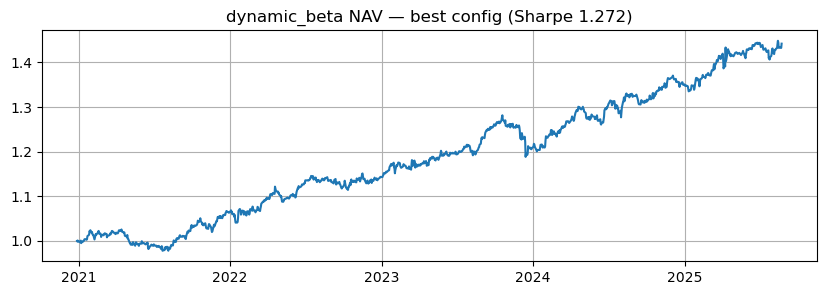


pca_resid — best params: {'entry_z': 1.1, 'exit_z': 0.45, 'stop_loss': 0.08} — Sharpe 1.2144 — ActiveDays 1238


WF periods (pca_resid): 100%|██████████| 81/81 [01:01<00:00,  1.31it/s]


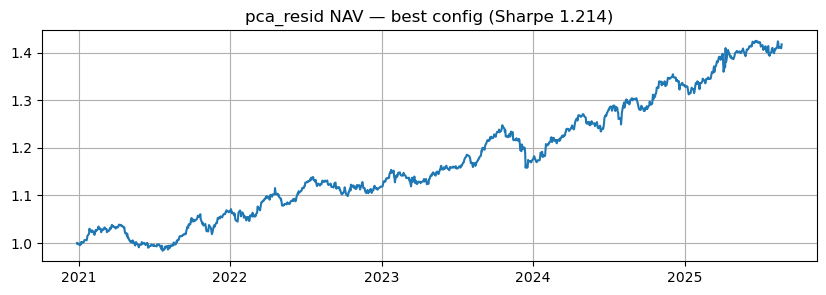


corrbreak — best params: {'corr_window': 30, 'corr_drop': 0.18, 'mom_window': 7, 'stop_loss': 0.08} — Sharpe 0.8381 — ActiveDays 1238


WF periods (corrbreak): 100%|██████████| 81/81 [01:26<00:00,  1.07s/it]


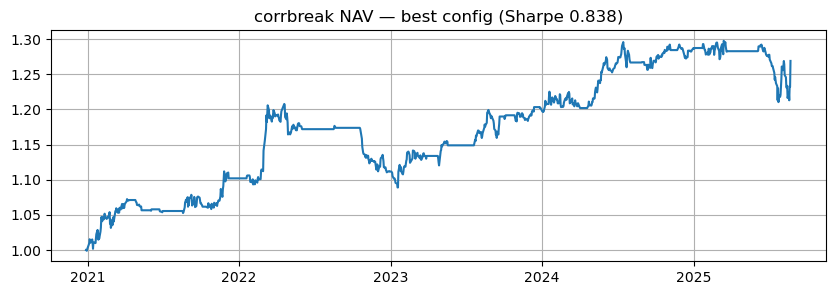


volswitch — best params: {'window': 15, 'thresh': 0.4} — Sharpe 1.1248 — ActiveDays 1238


WF periods (volswitch): 100%|██████████| 81/81 [00:32<00:00,  2.50it/s]


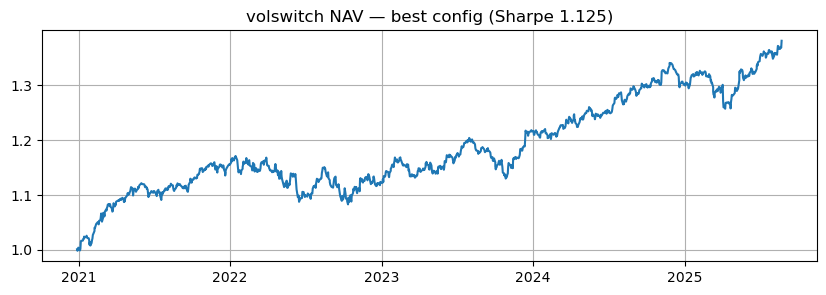


=== Sweep summary (best config per strategy) ===
    Strategy                                                                 BestParams   Sharpe     CAGR    MaxDD  ActiveDays  Bootstrap_p
dynamic_beta      {'beta_window': 20, 'entry_z': 1.5, 'exit_z': 0.6, 'stop_loss': 0.08} 1.272117 0.081929 0.093150        1238       0.0030
   pca_resid                        {'entry_z': 1.1, 'exit_z': 0.45, 'stop_loss': 0.08} 1.214378 0.077975 0.089524        1238       0.0050
   volswitch                                              {'window': 15, 'thresh': 0.4} 1.124803 0.071873 0.088062        1238       0.0065
   corrbreak {'corr_window': 30, 'corr_drop': 0.18, 'mom_window': 7, 'stop_loss': 0.08} 0.838070 0.052571 0.118779        1238       0.0305

Sweep complete. Detailed results available in 'sweep_all_results' and 'sweep_summary_df'.


In [16]:
# Parallel parameter sweep for problematic strategies (dynamic_beta, pca_resid, corrbreak, volswitch)
import itertools, json, warnings, traceback
from collections import Counter
from tqdm.auto import tqdm
from contextlib import contextmanager
from joblib import Parallel, delayed
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ------------------------
# tqdm <-> joblib bridge
# ------------------------
@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)
    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb
        tqdm_object.close()

# ------------------------
# Utilities (metrics, bootstrap, t-test)
# ------------------------
try:
    from scipy.stats import ttest_1samp
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

def metrics_from_returns(ret_series):
    if ret_series is None or len(ret_series) < 2:
        return {'CAGR': np.nan, 'Sharpe': np.nan, 'MaxDD': np.nan}
    nav = (1 + ret_series).cumprod()
    days = (nav.index[-1] - nav.index[0]).days if len(nav.index) > 1 else len(ret_series)
    years = days / 365.25 if days > 0 else len(ret_series) / 252.0
    cagr = (nav.iloc[-1] ** (1.0 / years) - 1) if years > 0 else np.nan
    ann_ret = float(ret_series.mean() * 252.0)
    ann_vol = float(ret_series.std(ddof=0) * np.sqrt(252.0))
    sharpe = float(ann_ret / (ann_vol + 1e-12)) if ann_vol > 0 else np.nan
    max_dd = float((nav.cummax() - nav).max())
    return {'CAGR': cagr, 'Sharpe': sharpe, 'MaxDD': max_dd}

def bootstrap_mean_pvalue(series, n_samples=2000, seed=123):
    x = series.dropna().values
    if len(x) == 0:
        return {'p_boot': np.nan, 'ci_low': np.nan, 'ci_high': np.nan, 'mean': np.nan}
    rng = np.random.default_rng(seed)
    means = rng.choice(x, size=(n_samples, len(x)), replace=True).mean(axis=1)
    p_boot = float((means <= 0.0).mean())
    ci_low, ci_high = np.percentile(means, [2.5, 97.5])
    return {'p_boot': p_boot, 'ci_low': float(ci_low), 'ci_high': float(ci_high), 'mean': float(means.mean())}

def ttest_mean(series):
    if not SCIPY_AVAILABLE:
        return {'t_stat': np.nan, 'pval': np.nan}
    x = series.dropna().values
    if len(x) < 2:
        return {'t_stat': np.nan, 'pval': np.nan}
    t, p = ttest_1samp(x, 0.0)
    return {'t_stat': float(t), 'pval': float(p)}

# ------------------------
# safe caller wrapper (uses global safe_walk_forward_call if present)
# ------------------------
if 'safe_walk_forward_call' in globals():
    _safe_call = globals()['safe_walk_forward_call']
else:
    # fallback to naive call to walk_forward_test - handle multiple signatures
    def _safe_call(strategy_name, param_grid, price_df_local=None, pairs_list_local=None, esabo_local=None, train_days=None, trade_days=None):
        price_df_local = price_df_local if price_df_local is not None else globals().get('price_df', globals().get('prices'))
        pairs_list_local = pairs_list_local if pairs_list_local is not None else globals().get('pairs', None)
        esabo_local = esabo_local if esabo_local is not None else globals().get('esabo_pairs_over_time', None)
        try:
            return walk_forward_test(strategy_name, param_grid=param_grid, price_df=price_df_local, pairs_list=pairs_list_local, esabo_pairs_over_time=esabo_local, train_days=train_days, trade_days=trade_days)
        except TypeError:
            try:
                return walk_forward_test(strategy_name, param_grid, price_df_local, pairs_list_local, esabo_local)
            except Exception:
                return walk_forward_test(strategy_name, param_grid)

# ------------------------
# Parameter grids (coarse) - you can expand or refine later
# ------------------------
GRIDS = {
    "dynamic_beta": {
        "beta_window": [20, 30, 40],
        "entry_z": [0.7, 1.0, 1.25, 1.5],
        "exit_z": [0.25, 0.35, 0.45, 0.6],
        "stop_loss": [0.08, 0.10, 0.15]
    },
    "pca_resid": {
        "entry_z": [0.6, 0.9, 1.1, 1.4],
        "exit_z": [0.25, 0.35, 0.45],
        "stop_loss": [0.08, 0.10, 0.12]
    },
    "corrbreak": {
        "corr_window": [20, 30, 40],
        "corr_drop": [0.10, 0.15, 0.18, 0.22],
        "mom_window": [3, 5, 7],
        "stop_loss": [0.08, 0.11, 0.14]
    },
    "volswitch": {
        "window": [15, 20, 30],
        "thresh": [0.0, 0.2, 0.4]   # thresh interpreted as multiplicative factor above baseline
    }
}

# ------------------------
# Top-level worker for a single combo
# ------------------------
def run_combo(strategy_name, params):
    """Run safe walk-forward with a single param dict and return summarized metrics."""
    try:
        wf = _safe_call(strategy_name, param_grid=[params], price_df_local=globals().get('price_df', globals().get('prices')), pairs_list_local=globals().get('pairs'), esabo_local=globals().get('esabo_pairs_over_time'))
    except Exception as e:
        return {'strategy': strategy_name, 'params': params, 'error': str(e), 'CAGR': np.nan, 'Sharpe': np.nan, 'MaxDD': np.nan, 'ActiveDays': 0}
    if wf is None or wf.get('oos_portfolio') is None:
        return {'strategy': strategy_name, 'params': params, 'error': 'no_oos', 'CAGR': np.nan, 'Sharpe': np.nan, 'MaxDD': np.nan, 'ActiveDays': 0}
    series = wf['oos_portfolio'].dropna()
    if series.empty:
        return {'strategy': strategy_name, 'params': params, 'error': 'empty_series', 'CAGR': np.nan, 'Sharpe': np.nan, 'MaxDD': np.nan, 'ActiveDays': 0}
    # compute metrics
    mets = metrics_from_returns(series)
    bs = bootstrap_mean_pvalue(series)
    tt = ttest_mean(series)
    # meta-stability: how many times params were selected in records (if available)
    recs = wf.get('records', pd.DataFrame())
    stability_count = 0
    stability_frac = 0.0
    if not recs.empty and 'best_params' in recs.columns:
        keys = recs['best_params'].apply(lambda d: json.dumps(d, sort_keys=True)).tolist()
        cnt = Counter(keys)
        k = json.dumps(params, sort_keys=True)
        stability_count = int(cnt.get(k, 0))
        stability_frac = float(stability_count / len(keys)) if len(keys) > 0 else 0.0
    return {
        'strategy': strategy_name,
        'params': params,
        'CAGR': mets['CAGR'],
        'Sharpe': mets['Sharpe'],
        'MaxDD': mets['MaxDD'],
        'ActiveDays': int(len(series)),
        'Bootstrap_p': bs['p_boot'],
        'Bootstrap_CI': (bs['ci_low'], bs['ci_high']),
        'Ttest_p': tt['pval'],
        'Stability_count': stability_count,
        'Stability_frac': stability_frac,
        'error': None
    }

# ------------------------
# Run grid sweep (parallel) for a single strategy
# ------------------------
def sweep_strategy_grid(strategy_name, grid, n_jobs=-1):
    # expand grid combos
    keys = list(grid.keys())
    values = [grid[k] for k in keys]
    combos = []
    for prod in itertools.product(*values):
        params = dict(zip(keys, prod))
        combos.append(params)
    if not combos:
        return pd.DataFrame()
    results = []
    # run in parallel with joblib + tqdm bridge
    with tqdm_joblib(tqdm(total=len(combos), desc=f"Sweep {strategy_name}", leave=True, miniters=1)):
        results = Parallel(n_jobs=n_jobs, prefer="threads", batch_size=1, verbose=0)(
            delayed(run_combo)(strategy_name, c) for c in combos
        )
    df = pd.DataFrame(results)
    # normalize param column to string for sorting / display
    df['params_str'] = df['params'].apply(lambda p: json.dumps(p, sort_keys=True))
    return df

# ------------------------
# Run sweeps for all problematic strategies and save results
# ------------------------
problematic = ['dynamic_beta', 'pca_resid', 'corrbreak', 'volswitch']
all_results = {}
for strat in problematic:
    print(f"\nStarting sweep for {strat} (grid size = ", end="")
    g = GRIDS.get(strat, {})
    size = 1
    for v in g.values():
        size *= len(v)
    print(size, ")")
    df = sweep_strategy_grid(strat, g, n_jobs=-1)
    # pick top 5 by Sharpe (drop NaNs)
    df_sorted = df.dropna(subset=['Sharpe']).sort_values(['Sharpe','CAGR'], ascending=False).reset_index(drop=True)
    all_results[strat] = {'raw': df, 'top': df_sorted.head(10)}
    print(f"Top configs for {strat}:")
    if df_sorted.empty:
        print("  (none produced OOS returns)")
    else:
        print(df_sorted[['params_str','Sharpe','CAGR','MaxDD','ActiveDays','Bootstrap_p']].head(5).to_string(index=False))

# ------------------------
# Plot NAV for best config of each strategy (if available)
# ------------------------
for strat, data in all_results.items():
    df = data['raw']
    df_valid = df.dropna(subset=['Sharpe']).sort_values(['Sharpe','CAGR'], ascending=False)
    if df_valid.empty:
        print(f"\n{strat}: no valid configs with OOS returns.")
        continue
    best_row = df_valid.iloc[0]
    best_params = best_row['params']
    print(f"\n{strat} — best params: {best_params} — Sharpe {best_row['Sharpe']:.4f} — ActiveDays {best_row['ActiveDays']}")
    # re-run to get wf and series (we did it already inside run_combo but didn't keep series to save memory)
    try:
        wf = _safe_call(strat, param_grid=[best_params], price_df_local=globals().get('price_df', globals().get('prices')), pairs_list_local=globals().get('pairs'), esabo_local=globals().get('esabo_pairs_over_time'))
        if wf and wf.get('oos_portfolio') is not None:
            series = wf['oos_portfolio'].dropna()
            if len(series) > 1:
                nav = (1 + series).cumprod()
                plt.figure(figsize=(10,3))
                plt.plot(nav.index, nav.values)
                plt.title(f"{strat} NAV — best config (Sharpe {best_row['Sharpe']:.3f})")
                plt.grid(True)
                plt.show()
                # store series & wf into all_results for inspection
                all_results[strat]['best_wf'] = wf
                all_results[strat]['best_series'] = series
    except Exception:
        traceback.print_exc()
        print(f"Failed to re-run best config for plotting for {strat}.")

# ------------------------
# Save to globals for further inspection
# ------------------------
globals()['sweep_all_results'] = all_results
# Flattened summary DataFrame across strategies
summary_rows = []
for strat, data in all_results.items():
    df = data['raw']
    if df is None or df.empty:
        continue
    # best by Sharpe
    dfv = df.dropna(subset=['Sharpe']).sort_values(['Sharpe','CAGR'], ascending=False)
    if dfv.empty:
        summary_rows.append({'Strategy': strat, 'BestParams': None, 'Sharpe': np.nan, 'CAGR': np.nan, 'MaxDD': np.nan, 'ActiveDays': 0})
    else:
        r = dfv.iloc[0]
        summary_rows.append({'Strategy': strat, 'BestParams': r['params'], 'Sharpe': r['Sharpe'], 'CAGR': r['CAGR'], 'MaxDD': r['MaxDD'], 'ActiveDays': r['ActiveDays'], 'Bootstrap_p': r['Bootstrap_p']})
summary_df = pd.DataFrame(summary_rows).sort_values('Sharpe', ascending=False).reset_index(drop=True)
globals()['sweep_summary_df'] = summary_df

print("\n=== Sweep summary (best config per strategy) ===")
print(summary_df.to_string(index=False))

print("\nSweep complete. Detailed results available in 'sweep_all_results' and 'sweep_summary_df'.")
